In [1]:
# a Python implementation of a model for intra-cluster light
# and an attempt to document it as we go

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.optimize
plt.rcParams.update({
'lines.linewidth':1.0,
'lines.linestyle':'-',
'lines.color':'black',
'font.family':'serif',
'font.weight':'normal',
'font.size':10.0,
'text.color':'black',
'text.usetex':True,
'axes.edgecolor':'black',
'axes.linewidth':1.0,
'axes.grid':False,
'axes.titlesize':'x-large',
'axes.labelsize':'x-large',
'axes.labelweight':'normal',
'axes.labelcolor':'black',
'axes.formatter.limits':[-4,4],
'xtick.major.size':7,
'xtick.minor.size':4,
'xtick.major.pad':8,
'xtick.minor.pad':8,
'xtick.labelsize':'x-large',
'xtick.minor.width':1.0,
'xtick.major.width':1.0,
'ytick.major.size':7,
'ytick.minor.size':4,
'ytick.major.pad':8,
'ytick.minor.pad':8,
'ytick.labelsize':'x-large',
'ytick.minor.width':1.0,
'ytick.major.width':1.0,
'legend.numpoints':1,
'legend.fontsize':'x-large',
'legend.shadow':False,
'legend.frameon':False})

import scipy
import fitsio


# some settings that you should not change; at least you can't expect anything is still correct if you do

from astropy.cosmology import FlatLambdaCDM
h=0.72
Om0=0.27
cosmo = FlatLambdaCDM(H0=h*100., Om0=Om0)

from math import pi,sqrt,pow,log,exp

njypc = 3.631 # nJy per count at ZP=30
mua = 2.5     # area factor for photometric method used -- 2.5 is DETMODEL, i.e. there the leakage is over 2.5 pi FLUX_RADIUS^2

In [2]:
# (0) some function we will need later

antonella_table = np.genfromtxt("evolving_red_gal.dat")
# z, Age, Age_sed, r_des, i_des, r_chft, i_chft
# for a passively evolving stellar population, 
# BC03 with solar metallicity, no dust, exponentially declining SFH with tau=0.1, Age =10 Gyr at z=0
antonella_column = {}
antonella_column['rDES'] = 3
antonella_column['iDES'] = 4
antonella_column['rCFHT'] = 5
antonella_column['iCFHT'] = 6
antonella_column['z'] = 0

def get_mag_antonella(z,filter):
# magnitudes of a red galaxy template as a function of redshift
# allows conversion of colors between DES r,i and CFHT r,i and also luminosity evolution of an ageing stellar population
    return np.interp(z,antonella_table[:,antonella_column['z']],antonella_table[:,antonella_column[filter]])

def int_schechter(l1,l2): 
    alpha=-1
    # int_a^b x x^{alpha} e^{-x} dx ~ (incomplete_Gamma(alpha-1,a)-incomplete_Gamma(alpha-1,b))
    return scipy.special.gammainc(alpha+2,l2)-scipy.special.gammainc(alpha+2,l1)
    
mstar=fitsio.read("mstar_des_i03.fit")
mstar_z=[m[0] for m in mstar]
mstar_m=[m[1] for m in mstar]

def mstar_filter(z,filter="rDES"):
# m* magnitude in any of these four filters
    return np.interp(z,mstar_z,mstar_m)+get_mag_antonella(z,filter)-get_mag_antonella(z,"iDES")


# ICL profiles from Yuanyuan

def read_ICL_resampled_profile_pure(id): # new, pure profile
    icl=np.genfromtxt("jacknife_profiles_0.15_rand_back_subtracted_corZ_faintgalsub/jacknife_profile_"+str(id)+".txt",delimiter=",")
    #print(icl)
    r=icl[:,0] # proper kpc
    f_r=icl[:,3]/(0.263**2) # counts per arcsec^2, r band, ZP=30
    return r,f_r

def read_ICL_mean_profile_pure():
    njack=40
    nbins=266
    r_jack=np.zeros(nbins)
    f_r_jack=np.zeros(nbins)
    for i in range(njack):
        r,f_r = read_ICL_resampled_profile_pure(i)
        r_jack += r
        f_r_jack += f_r
        #print(r_jack[0])
        
    return r_jack/njack,f_r_jack/njack

def smooth_vectors(r,f,minsmoothing,smoothing):

    smoothmatrix=np.zeros((len(r),len(r)))
    for i in range(smoothing):
        smoothmatrix[-(i+1),-(i+1)]=1.
    for i in range(minsmoothing+smoothing):
        smoothmatrix[i,i]=1.
        
    for i in range(minsmoothing+smoothing,len(r)-smoothing):
        smoothmatrix[i-smoothing:i+1+smoothing,i]=r[i-smoothing:i+1+smoothing]/sum(r[i-smoothing:i+1+smoothing])

    r=np.dot(r,smoothmatrix)
    f=np.dot(f,smoothmatrix)
    return r,f

def f_m_z_pure(m=3.e14,z=0.25,filter="iCFHT"):
# get ICL flux (units in counts per arcsec^2 at ZP 30) for clusters at given mass, redshift, and in given filter
    r,f=read_ICL_mean_profile_pure() #rDES
    
    zfid=0.25
    mfid=3.e14 # M200m, h_72^-1
    
    # now assume the same configuration gets put at a different redshift
    # fix the physical stellar surface density

    # (1) re-scale for angular diameter: D_A^{-2}
    f *= (cosmo.angular_diameter_distance(z).value/cosmo.angular_diameter_distance(zfid).value)**2
    # surface flux is larger if cluster is smaller in the sky = larger angular diameter distance
    
    # (2) re-scale for (filter,z)-(iCFHT,0.25) color, which contains luminosity distance
    color = get_mag_antonella(z,filter)-get_mag_antonella(zfid,"rDES")
    f *= 10**(-0.4*color)
    # if color is large, then object is fainter in filter than in rDES, then flux is smaller in filter than in rDES
    
    # (3) re-scale for mass
    # simple assumption ~valid from Yuanyuan's paper: it's all the same if you look at r in r500 units
    # also blatantly ignoring concentration 
    r *= (m/mfid)**(1./3.)

    return r,f

def f_m_z_pure_smooth(m=3.e14,z=0.25,r=np.arange(10,1000,10),filter="iCFHT",minsmoothing=20,smoothing=2):
# get ICL flux (units in ZP 30 per arcsec^2) for clusters at given mass, redshift, and in given filter
    r,f=read_ICL_mean_profile_pure() #rDES
    
    zfid=0.25
    mfid=3.e14 # M200m, h_72^-1
    
    # now assume the same configuration gets put at a different redshift
    # fix the physical stellar surface density

    # (1) re-scale for angular diameter: D_A^{-2}
    f *= (cosmo.angular_diameter_distance(z).value/cosmo.angular_diameter_distance(zfid).value)**2
    # surface flux is larger if cluster is smaller in the sky = larger angular diameter distance
    
    # (2) re-scale for (filter,z)-(iCFHT,0.25) color, which contains luminosity distance
    color = get_mag_antonella(z,filter)-get_mag_antonella(zfid,"rDES")
    f *= 10**(-0.4*color)
    # if color is large, then object is fainter in filter than in rDES, then flux is smaller in filter than in rDES
    
    # (3) re-scale for mass
    # simple assumption ~valid from Yuanyuan's paper: it's all the same if you look at r in r500 units
    # also blatantly ignoring concentration 
    r *= (m/mfid)**(1./3.)

    return smooth_vectors(r,f,minsmoothing,smoothing)

def f_m_z_r_pure(m=3.e14, z=0.25, r=np.arange(10,1000,10), filter="iCFHT"):
# the same, but on your preferred grid in r
    rin, fin = f_m_z_pure(m=m,z=z,filter=filter)
    return np.interp(r,rin,fin) # life can be so easy


def f_m_z_r_pure_smooth(m=3.e14,z=0.25,r=np.arange(10,1000,10),filter="iCFHT",minsmoothing=27,smoothing=10):
    rin, fin = f_m_z_pure_smooth(m=m,z=z,filter=filter,minsmoothing=minsmoothing,smoothing=smoothing)
    return np.interp(r,rin,fin) # life can be so easy

In [8]:
# this is how you do it


f0=f_m_z_r_pure_smooth(m=10**(14.8),                 # M200m, h_72^-1
                    z=0.325,
                    r=np.arange(10,1000,10), # proper kpc
                    filter='iDES'            # currently only rDES and iDES implemented
                   )
f1=f_m_z_r_pure_smooth(m=10**(14.8),                 # M200m, h_72^-1
                    z=0.475,
                    r=np.arange(10,1000,10), # proper kpc
                    filter='iDES'            # currently only rDES and iDES implemented
                   )
f2=f_m_z_r_pure_smooth(m=10**(14.8),                 # M200m, h_72^-1
                    z=0.625,
                    r=np.arange(10,1000,10), # proper kpc
                    filter='iDES'            # currently only rDES and iDES implemented
                   )

# output is in counts per arcsec^2 assuming a zeropoint of 30 -- careful to convert this in counts/pixel at your ZP properly


Text(0,0.5,'counts per arcsec$^2$ at ZP=30 in DES r')

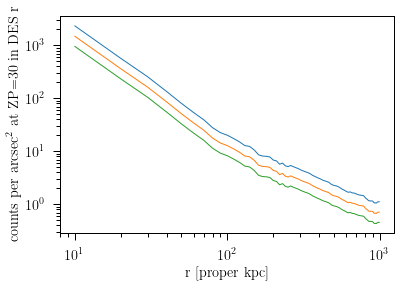

In [9]:
plt.loglog(np.arange(10,1000,10),f0)
plt.loglog(np.arange(10,1000,10),f1)
plt.loglog(np.arange(10,1000,10),f2)
plt.xlabel("r [proper kpc]")
plt.ylabel(r"counts per arcsec$^2$ at ZP=30 in DES r")